In [ ]:
import string
import random
import numpy as np
import re
import os
import requests
import copy

from copy import copy

import matplotlib.pyplot as plt

# Encoder class
class Encoder:
    def __init__(self):
        self.__build_cipher_mapping()

    def __build_cipher_mapping(self):
        """ Builds the substitution cipher mapping for 26 letters """
        random.seed(7)
        letters_original = list(string.ascii_lowercase)
        letters_shuffled = random.sample(
            list(string.ascii_lowercase), len(list(string.ascii_lowercase))
        )
        self.encoder_cipher_mapping = {
            letters_original[i]: letters_shuffled[i] for i in range(len(letters_original))
        }

    def encode(self, message):
        """ Method to encode the message using the cipher mapping """
        message = re.sub("[^a-zA-Z]", " ", message)
        message_tokens = list(message.lower())
        for i in range(len(message)):
            if message_tokens[i] in self.encoder_cipher_mapping:
                message_tokens[i] = self.encoder_cipher_mapping[message_tokens[i]]
        encoded_message = "".join(message_tokens)
        return encoded_message

    def decode(self, encoded_message, mapping):
        """ Method to decode the message using the cipher mapping """
        message_tokens = list(encoded_message.lower())
        for i in range(len(encoded_message)):
            if message_tokens[i] in mapping:
                message_tokens[i] = mapping[message_tokens[i]]
        decoded_message = "".join(message_tokens)
        return decoded_message


class LanguageModel:
    """Build a language model using Moby Dick text corpus"""

    def __init__(self):
        self.build()

    def __load_data(self):
        """Load the text data as the corpus"""
        _init_file_dir = os.getcwd()  # Get the current working directory
        if os.path.exists(os.path.join(_init_file_dir, "data/moby_dick.txt")):
            with open(os.path.join(_init_file_dir, "data/moby_dick.txt"), "r") as file:
                self.corpus = file.read()
        else:
            url = "https://lazyprogrammer.me/course_files/moby_dick.txt"
            response = requests.get(url)
            self.corpus = response.content.decode("utf-8")

    def __initialize_bigram_transition_probabilities(self):
        """Transition probabilities, represents the probability of going from 1 character to another."""
        self.M = np.ones((26, 26))  # Initialize to a matrix with all 1s for smoothing

    def __initialize_unigram_distributions(self):
        """Probability distributions for the initial letters."""
        self.pi = np.zeros(26)

    @staticmethod
    def letter_to_index(letter):
        """Convert letter to index"""
        return ord(letter) - 97

    def __update_transition_probability(self, char1, char2):
        """Update transition probability from char1 to char2."""
        i = self.letter_to_index(char1)
        j = self.letter_to_index(char2)
        self.M[i, j] += 1

    def __update_unigram_distribution(self, char):
        i = self.letter_to_index(char)
        self.pi[i] += 1

    def build(self):
        """Build the language model for English language."""
        self.__load_data()
        self.__initialize_bigram_transition_probabilities()
        self.__initialize_unigram_distributions()

        # Clean and tokenize the corpus
        self.corpus = re.sub("[^a-zA-Z]", " ", self.corpus)
        tokens = self.corpus.lower().split()

        # Update unigram and bigram probabilities
        for token in tokens:
            self.__update_unigram_distribution(token[0])
            for i in range(len(token) - 1):
                self.__update_transition_probability(token[i], token[i + 1])

        # Convert counts to probabilities
        self.log_M = np.log(self.M / self.M.sum(axis=1, keepdims=True))
        self.log_pi = np.log(self.pi / self.pi.sum())

    def get_log_word_probability(self, word):
        """Get log probability of a word"""
        first_letter_index = self.letter_to_index(word[0])
        log_unigram_prob = self.log_pi[first_letter_index] if first_letter_index in np.arange(26) else 0
        log_bigram_prob = 0

        for i in range(len(word) - 1):
            starting_letter_index = self.letter_to_index(word[i])
            ending_letter_index = self.letter_to_index(word[i + 1])
            log_bigram_prob += (
                self.log_M[starting_letter_index][ending_letter_index]
                if (starting_letter_index in np.arange(26)) and (ending_letter_index in np.arange(26))
                else 0
            )

        return log_unigram_prob + log_bigram_prob

    def get_sentence_log_probability(self, sentence):
        """Get log probability of a sentence"""
        tokens = sentence.split()
        return sum([self.get_log_word_probability(token) for token in tokens])


# Genetic Algorithm class
class GeneticAlgorithm:
    POOL_SIZE = 20
    OFFSPRING_POOL_SIZE = 5
    NUM_ITER = 250

    def __init__(self):
        self.__initialize_dna_pool()
        self.__initialize_encoder()
        self.__initialize_language_model()

    def __initialize_dna_pool(self):
        """Generates a DNA pool"""
        self.all_letters = list(string.ascii_lowercase)
        self.dna_pool = [
            "".join(list(np.random.permutation(self.all_letters)))
            for _ in range(self.POOL_SIZE)
        ]
        self.offspring_pool = []

    def __initialize_encoder(self):
        """Initialize Encoder object"""
        self.encoder = Encoder()

    def __initialize_language_model(self):
        """Initialize LanguageModel object"""
        self.m = LanguageModel()

    @staticmethod
    def random_swap(sequence):
        """Randomly swap two characters in the sequence"""
        index_1, index_2 = random.sample(list(np.arange(len(sequence))), 2)
        sequence_copy = copy(sequence)
        seq_list = list(sequence_copy)
        seq_list[index_1], seq_list[index_2] = seq_list[index_2], seq_list[index_1]
        return "".join(seq_list)

    def evolve_offspring(self):
        """Evolve offspring by random swaps for each DNA sequence"""
        for dna in self.dna_pool:
            self.offspring_pool += [
                self.random_swap(dna) for _ in range(self.OFFSPRING_POOL_SIZE)
            ]
        return self.offspring_pool + self.dna_pool

    def train(self, initial_message):
        """Train the Genetic Algorithm"""
        self.avg_scores_per_iter = np.zeros(self.NUM_ITER)
        self.best_scores_per_iter = np.zeros(self.NUM_ITER)
        self.best_dna = None
        self.best_mapping = None
        self.best_score = float("-inf")
        dna_scores = {}

        # Encode initial message
        encoded_message = self.encoder.encode(initial_message)

        for i in range(self.NUM_ITER):
            if i > 0:
                self.dna_pool = self.evolve_offspring()

            for dna in self.dna_pool:
                curr_mapping = {original_letter: encoded_letter for original_letter, encoded_letter in zip(self.all_letters, dna)}
                curr_decoded_message = self.encoder.decode(encoded_message, curr_mapping)
                dna_scores[dna] = self.m.get_sentence_log_probability(curr_decoded_message)

                if dna_scores[dna] > self.best_score:
                    self.best_score = dna_scores[dna]
                    self.best_mapping = curr_mapping
                    self.best_dna = dna

            self.avg_scores_per_iter[i] = np.mean(list(dna_scores.values()))
            self.best_scores_per_iter[i] = self.best_score

            sorted_dna_curr_gen = sorted(dna_scores.items(), key=lambda x: x[1], reverse=True)
            self.dna_pool = [sequence[0] for sequence in sorted_dna_curr_gen[:5]]

            if i in np.arange(0, 251, 50):
                print(
                    "\n iter: {},".format(i),
                    "log likelihood: {},".format(self.avg_scores_per_iter[i]),
                    "best likelihood so far: {}".format(self.best_score),
                    "\n decoded_message: \n {} \n".format(self.encoder.decode(encoded_message, self.best_mapping))
                )


# Run the Genetic Algorithm and decode the message
original_message = """I then lounged down the street and found, as I expected, that there was a mews in a lane which
 runs down by one wall of the garden. I lent the ostlers a hand in rubbing down their horses, and received in exchange twopence,
 a glass of half-and-half, two fills of shag tobacco, and as much information as I could desire about Miss Adler."""
print("original_message\n")
print(original_message)

g = GeneticAlgorithm()
g.train(original_message)

best_mapping = g.best_mapping
encoder = Encoder()
encoded_message = encoder.encode(original_message)
decoded_message = encoder.decode(encoded_message, best_mapping)

lm = LanguageModel()
print("LL of decoded message:", lm.get_sentence_log_probability(decoded_message))
print("LL of true message:", lm.get_sentence_log_probability(re.sub("[^a-zA-Z]", " ", original_message.lower())))





original_message

I then lounged down the street and found, as I expected, that there was a mews in a lane which
 runs down by one wall of the garden. I lent the ostlers a hand in rubbing down their horses, and received in exchange twopence,
 a glass of half-and-half, two fills of shag tobacco, and as much information as I could desire about Miss Adler.

 iter: 0, log likelihood: -1425.4628131763097, best likelihood so far: -1169.7031657366244 
 decoded_message: 
 i stmg rafgkme eaqg stm hsnmms oge bafge  oh i mpzmwsme  stos stmnm qoh o jmqh ig o rogm qtiwt  nfgh eaqg lu agm qorr ab stm konemg  i rmgs stm ahsrmnh o toge ig nflligk eaqg stmin tanhmh  oge nmwmivme ig mpwtogkm sqazmgwm   o krohh ab torb oge torb  sqa birrh ab htok salowwa  oge oh jfwt igbanjosiag oh i wafre emhinm olafs jihh oermn  


 iter: 50, log likelihood: -921.6874537653079, best likelihood so far: -702.551691155938 
 decoded_message: 
 i ther pourdes sowr the ntmeet ars fours  an i exvectes  that theme wan a bewn i

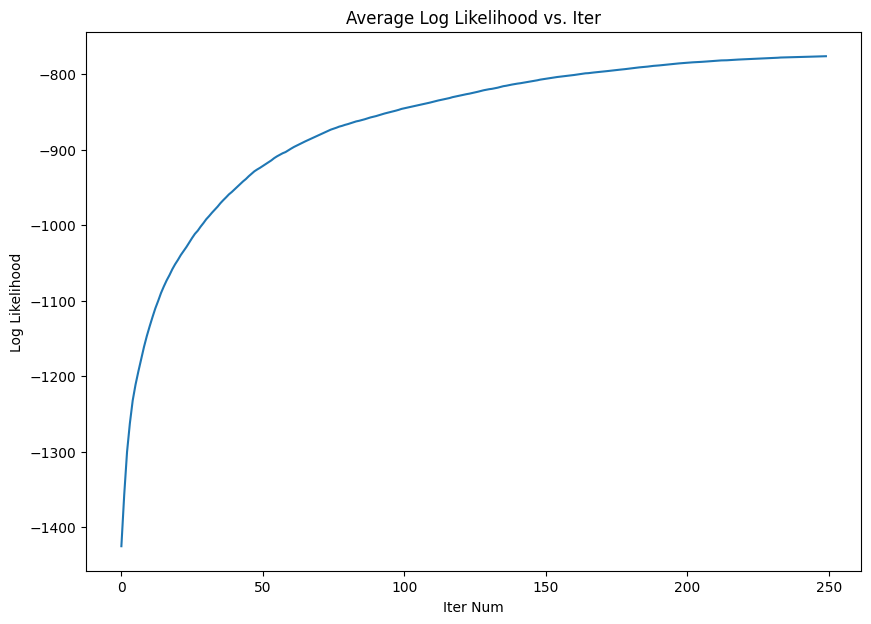

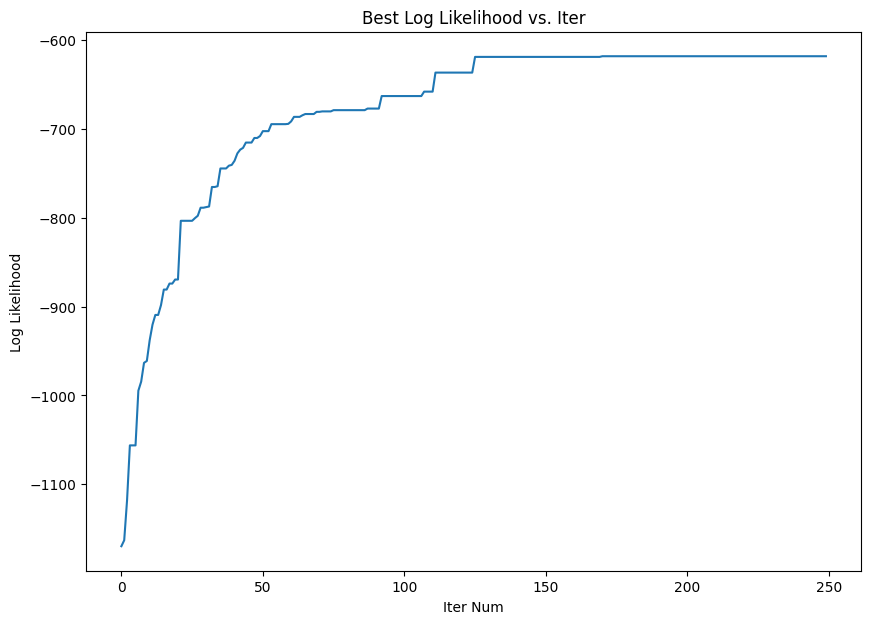

In [ ]:
# Visualize the training progression
plt.figure(figsize=(10, 7))
plt.plot(g.avg_scores_per_iter)
plt.title("Average Log Likelihood vs. Iter")
plt.xlabel("Iter Num")
plt.ylabel("Log Likelihood")

plt.figure(figsize=(10, 7))
plt.plot(g.best_scores_per_iter)
plt.title("Best Log Likelihood vs. Iter")
plt.xlabel("Iter Num")
plt.ylabel("Log Likelihood")
plt.show()